Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Deep Dive

* Comparing synthetic data prediction results and real data prediction results, dive deep to see what might be the reasons for predicted probability changes.
* Categorical features are encoded so that SHAP force plot can show their contributions too.

In [1]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from category_encoders import TargetEncoder

import optuna
import shap
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Load Data

In [2]:
target = 'deposit'
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_cols = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'poutcome']

raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/campaign_deposit.pkl')
X_train, X_test, y_train, y_test = train_test_split(raw_df.drop(target, axis=1), raw_df[target], 
                                                    test_size=0.25, random_state=10,
                                                    stratify=raw_df[target])
X_train.reset_index(drop=True, inplace=True) 
X_test.reset_index(drop=True, inplace=True) 
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

ctgan_syn_X_train = pd.read_csv('ctgan_syn_X_train_10.csv')
castgan_syn_X_train = pd.read_csv('CasTGAN/Generated_Data/wb_0/campaign_fake_20230901-2310.csv')

print(ctgan_syn_X_train.shape, castgan_syn_X_train.shape)

(8371, 16) (2791, 16) (8371,) (2791,)
(8371, 16) (8371, 16)


In [3]:
def encode_data(cat_cols, X_train, y_train, X_test=None):
    enc = TargetEncoder(cols=cat_cols)
    encoded_X_train = enc.fit_transform(X_train, y_train)
    
    if X_test is not None:
        encoded_X_test = enc.transform(X_test)
        return encoded_X_train, encoded_X_test
    else:
        return encoded_X_train


encoded_X_train, encoded_X_test = encode_data(cat_cols, X_train, y_train, X_test)
encoded_ctgan_syn_X_train = encode_data(cat_cols, ctgan_syn_X_train, y_train)
encoded_castgan_syn_X_train = encode_data(cat_cols, castgan_syn_X_train, y_train)

print(encoded_X_train.shape, encoded_X_test.shape)
print(encoded_ctgan_syn_X_train.shape, encoded_castgan_syn_X_train.shape)

(8371, 16) (2791, 16)
(8371, 16) (8371, 16)


## Deep Dive - CTGAN

In [4]:
shap.initjs()

In [5]:
# real data used LGBM
model_params = {'num_leaves': 4, 'learning_rate': 0.17937097905882862,
                'bagging_fraction': 0.8506740422636537,
                'feature_fraction': 0.6643670461510903, 
                'bagging_freq': 18, 'min_data_in_leaf': 1133,
                'num_iterations': 2956, 'objective': 'binary',
                'metric': 'auc', 'random_state': 10,
                'verbosity': -1, 'boosting': 'gbdt',
                'num_threads': 4}

model_real = LGBMClassifier(**model_params)
model_real.fit(encoded_X_train, y_train)
y_pred1 = model_real.predict(encoded_X_test)
y_pred1_proba = model_real.predict_proba(encoded_X_test)[:, 1]  # positive probability
auc = roc_auc_score(y_test, y_pred1)
avp = average_precision_score(y_test, y_pred1)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')

Testing AUC is 0.8364289105456284, Testing Average Precision is 0.7604416464773803


In [6]:
# CTGAN used LGBM
model_params = {'num_leaves': 4, 'learning_rate': 0.17937097905882862, 
                'bagging_fraction': 0.8506740422636537,
                'feature_fraction': 0.6643670461510903,
                'bagging_freq': 18, 'min_data_in_leaf': 1133,
                'num_iterations': 2956, 'objective': 'binary',
                'metric': 'auc', 'random_state': 10,
                'verbosity': -1, 'boosting': 'gbdt',
                'num_threads': 4}

model_ctgan = LGBMClassifier(**model_params)
model_ctgan.fit(encoded_ctgan_syn_X_train, y_train)
y_pred2 = model_ctgan.predict(encoded_X_test)
y_pred2_proba = model_ctgan.predict_proba(encoded_X_test)[:, 1]  # positive probability
auc = roc_auc_score(y_test, y_pred2)
avp = average_precision_score(y_test, y_pred2)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')  # using target encoding seems lowered the performance

Testing AUC is 0.5019428244228427, Testing Average Precision is 0.4746394231950511


In [7]:
# get records prediction differences
pred_df = pd.DataFrame({'y_true': y_test,
                        'real_data_pos_pred_proba': y_pred1_proba,
                        'ctgan_data_pos_pred_proba': y_pred2_proba})
pred_df['real_ctgan_pred_diff'] = pred_df['real_data_pos_pred_proba'] - pred_df['ctgan_data_pos_pred_proba']
sorted_pred_df_ctgan = pred_df.sort_values(by='real_ctgan_pred_diff', ascending=False)
display(sorted_pred_df_ctgan.head())
display(sorted_pred_df_ctgan.tail())

,y_true,real_data_pos_pred_proba,ctgan_data_pos_pred_proba,real_ctgan_pred_diff
938,1,0.962169,0.207964,0.754205
1762,1,0.969064,0.228613,0.740451
163,1,0.970519,0.231262,0.739257
1733,0,0.968761,0.237322,0.731438
587,0,0.977648,0.250477,0.727171


,y_true,real_data_pos_pred_proba,ctgan_data_pos_pred_proba,real_ctgan_pred_diff
1978,0,0.002199,0.716603,-0.714404
152,0,0.003470,0.722759,-0.719289
2298,0,0.013727,0.743278,-0.729552
2136,0,0.003050,0.740994,-0.737943
1558,0,0.012593,0.770459,-0.757866


In [8]:
def get_shap_values(model, training_data, testing_data):
    explainer = shap.TreeExplainer(model, 
                                   data=training_data, # the trick to get SHAP in [0, 1] range
                                   model_output='probability', # the trick to get SHAP in [0, 1] range
                                   feature_dependence='independent' # the trick to get SHAP in [0, 1] range
                                  )
    shap_values = explainer(testing_data)
    expected_tree = explainer.expected_value
    if isinstance(expected_tree, list):
        expected_tree = expected_tree[1]
    
    return expected_tree, shap_values

In [9]:
base_real, shap_values_real = get_shap_values(model_real, encoded_X_train, encoded_X_test)
print(base_real)

100%|===================| 2790/2791 [03:00<00:00]        

0.48921146745112504


In [10]:
base_ctgan, shap_values_ctgan = get_shap_values(model_ctgan, encoded_ctgan_syn_X_train, encoded_X_test)
print(base_ctgan)

100%|===================| 2788/2791 [03:12<00:00]        

0.4746444160104921


(101, 4)


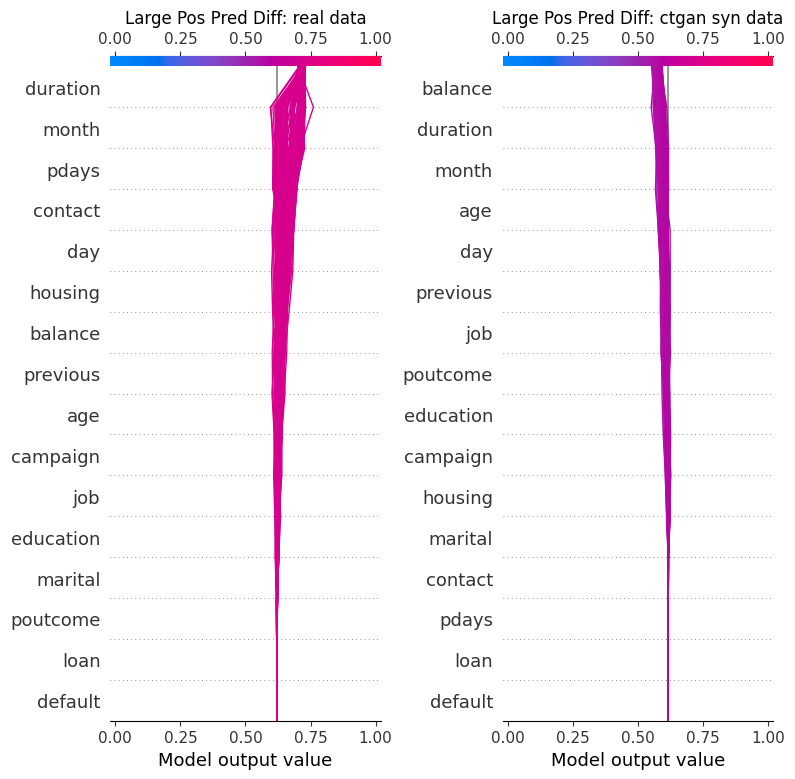

In [11]:
# largest positive differences
ctgan_large_pos_diff = sorted_pred_df_ctgan[(sorted_pred_df_ctgan['real_ctgan_pred_diff'] >= 0.6) \
                                            & (sorted_pred_df_ctgan['y_true'] == 1)]
print(ctgan_large_pos_diff.shape)

shap_values_real_large_pos_diff = shap_values_real.values[ctgan_large_pos_diff.index, :]
shap_values_ctgan_large_pos_diff = shap_values_ctgan.values[ctgan_large_pos_diff.index, :]

plt.subplot(1, 2, 1)
shap.decision_plot(base_real, shap_values_real_large_pos_diff,
                   feature_names=list(encoded_X_test.columns),
                   link="logit", show=False,
                  title='Large Pos Pred Diff: real data')

plt.subplot(1, 2, 2)
shap.decision_plot(base_ctgan, shap_values_ctgan_large_pos_diff,
                   feature_names=list(encoded_X_test.columns),
                   link="logit", show=False,
                  title='Large Pos Pred Diff: ctgan syn data')
plt.tight_layout()
plt.show()

(74, 4)


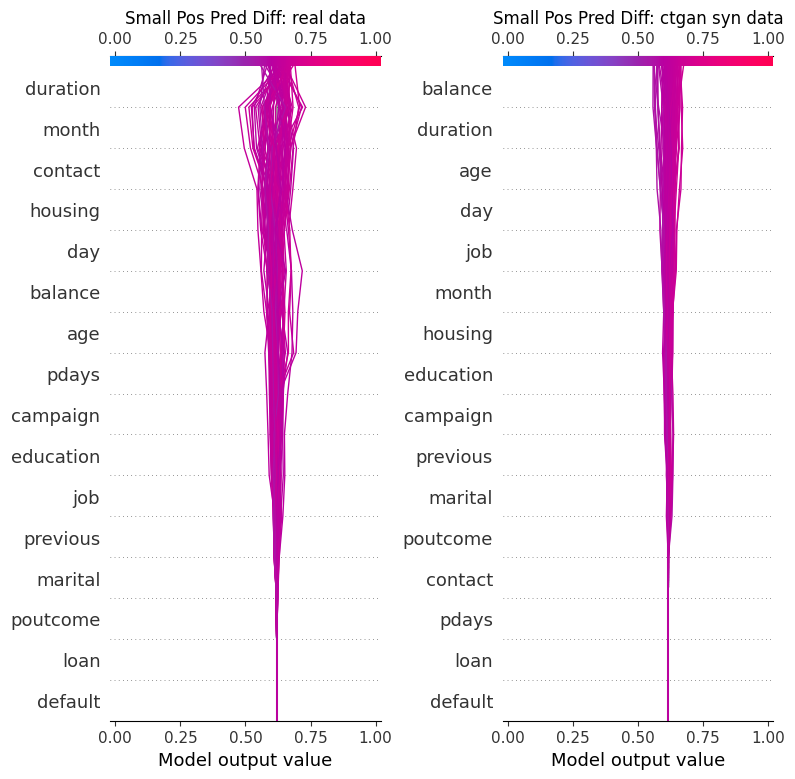

In [12]:
# small positive differences
ctgan_small_pos_diff = sorted_pred_df_ctgan[(sorted_pred_df_ctgan['real_ctgan_pred_diff'] < 0.1) \
                                            & (sorted_pred_df_ctgan['real_ctgan_pred_diff'] > 0) \
                                            & (sorted_pred_df_ctgan['y_true'] == 1)]
print(ctgan_small_pos_diff.shape)

shap_values_real_small_pos_diff = shap_values_real.values[ctgan_small_pos_diff.index, :]
shap_values_ctgan_small_pos_diff = shap_values_ctgan.values[ctgan_small_pos_diff.index, :]

plt.subplot(1, 2, 1)
shap.decision_plot(base_real, shap_values_real_small_pos_diff,
                   feature_names=list(encoded_X_test.columns),
                   link="logit", show=False,
                  title='Small Pos Pred Diff: real data')

plt.subplot(1, 2, 2)
shap.decision_plot(base_ctgan, shap_values_ctgan_small_pos_diff,
                   feature_names=list(encoded_X_test.columns),
                   link="logit", show=False,
                  title='Small Pos Pred Diff: ctgan syn data')
plt.tight_layout()
plt.show()

(74, 4)


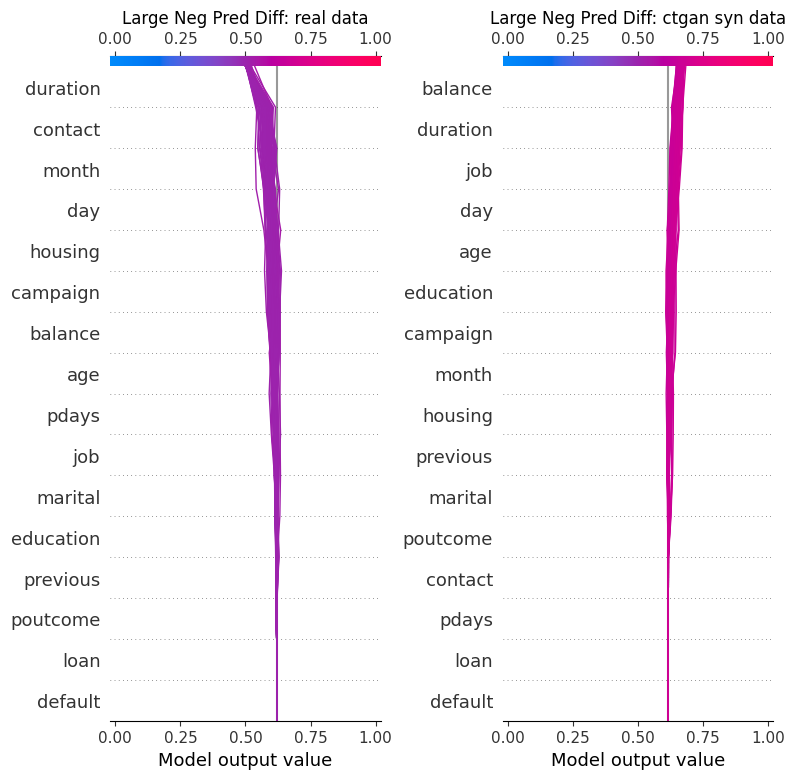

In [13]:
# largest negative differences
ctgan_large_neg_diff = sorted_pred_df_ctgan[(sorted_pred_df_ctgan['real_ctgan_pred_diff'] <= -0.6) \
                                            & (sorted_pred_df_ctgan['y_true'] == 0)]
print(ctgan_large_neg_diff.shape)

shap_values_real_large_neg_diff = shap_values_real.values[ctgan_large_neg_diff.index, :]
shap_values_ctgan_large_neg_diff = shap_values_ctgan.values[ctgan_large_neg_diff.index, :]

plt.subplot(1, 2, 1)
shap.decision_plot(base_real, shap_values_real_large_neg_diff,
                   feature_names=list(encoded_X_test.columns),
                   link="logit", show=False,
                  title='Large Neg Pred Diff: real data')

plt.subplot(1, 2, 2)
shap.decision_plot(base_ctgan, shap_values_ctgan_large_neg_diff,
                   feature_names=list(encoded_X_test.columns),
                   link="logit", show=False,
                  title='Large Neg Pred Diff: ctgan syn data')
plt.tight_layout()
plt.show()

(64, 4)


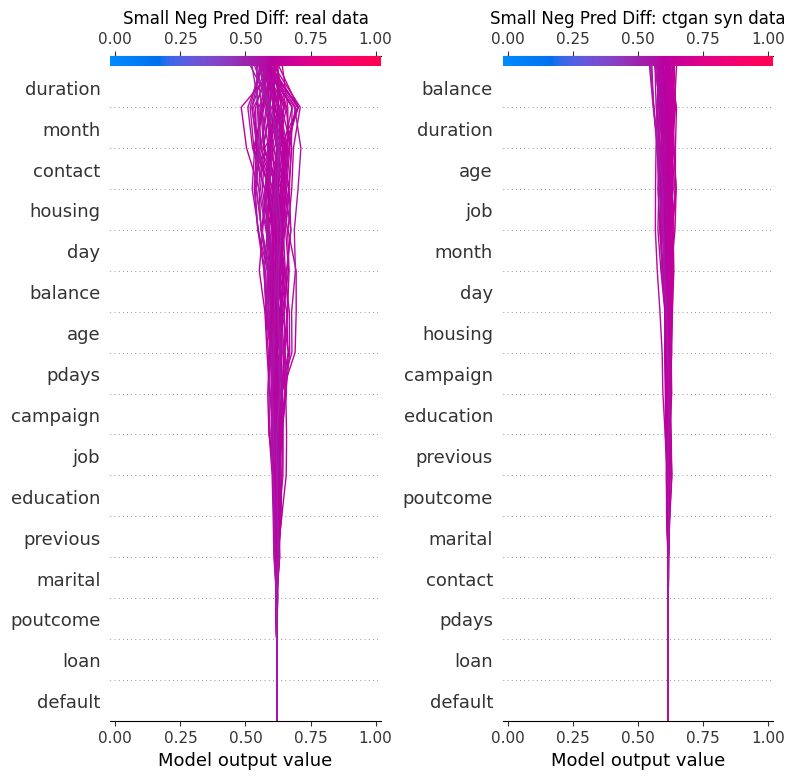

In [14]:
# small negative differences
ctgan_small_neg_diff = sorted_pred_df_ctgan[(sorted_pred_df_ctgan['real_ctgan_pred_diff'] >= -0.1) \
                                            & (sorted_pred_df_ctgan['real_ctgan_pred_diff'] < 0)
                                            & (sorted_pred_df_ctgan['y_true'] == 0)]
print(ctgan_small_neg_diff.shape)

shap_values_real_small_neg_diff = shap_values_real.values[ctgan_small_neg_diff.index, :]
shap_values_ctgan_small_neg_diff = shap_values_ctgan.values[ctgan_small_neg_diff.index, :]

plt.subplot(1, 2, 1)
shap.decision_plot(base_real, shap_values_real_small_neg_diff,
                   feature_names=list(encoded_X_test.columns),
                   link="logit", show=False,
                  title='Small Neg Pred Diff: real data')

plt.subplot(1, 2, 2)
shap.decision_plot(base_ctgan, shap_values_ctgan_small_neg_diff,
                   feature_names=list(encoded_X_test.columns),
                   link="logit", show=False,
                  title='Small Neg Pred Diff: ctgan syn data')
plt.tight_layout()
plt.show()

In [15]:
idx = 938

shap_force_plot_real = shap.force_plot(base_real, shap_values_real.values[idx, :],
                                       encoded_X_test.iloc[idx, :])
display(shap_force_plot_real)

shap_force_plot_ctgan = shap.force_plot(base_ctgan, shap_values_ctgan.values[idx, :],
                                        encoded_X_test.iloc[idx, :])
display(shap_force_plot_ctgan)

In [16]:
idx = 1558

shap_force_plot_real = shap.force_plot(base_real, shap_values_real.values[idx, :],
                                       encoded_X_test.iloc[idx, :])
display(shap_force_plot_real)

shap_force_plot_ctgan = shap.force_plot(base_ctgan, shap_values_ctgan.values[idx, :],
                                        encoded_X_test.iloc[idx, :])
display(shap_force_plot_ctgan)

In [17]:
def plot_num_feature_distribution_per_group(grouped_df, group_col, n_rows, n_cols, exclude_col=[], 
                                            figsize=[20, 10], font_scale=1, 
                                            bins=100, palette=["red", "blue", "green"]):
    sns.set(font_scale=font_scale)
    f, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1]))
    
    features = [col for col in grouped_df.columns if col not in exclude_col]
    for ax, feature in zip(axes.flat, features):
        sns.histplot(grouped_df, x=feature,
                     hue=group_col, ax=ax,
                     stat='density', palette=palette, bins=bins)

In [18]:
# check top impactful features' distrbution in positive class (real trainning data vs CTGAN training data)
sel_features = ['duration', 'contact', 'month', 'day', 'housing',
               'balance', 'job', 'age', 'default', 'loan']

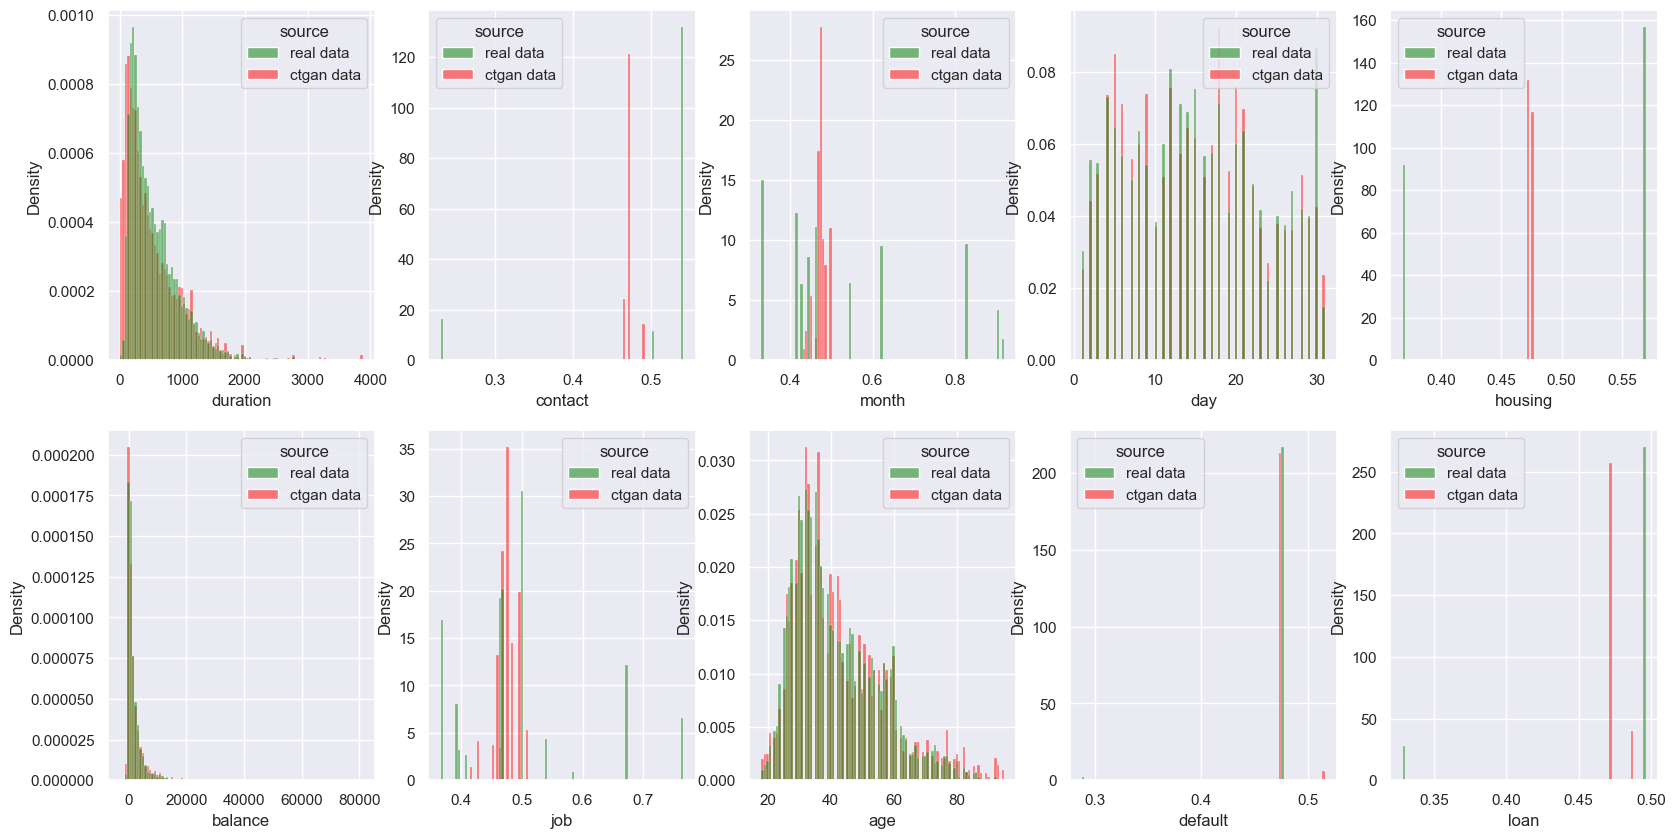

In [19]:
pos_real_train_df = encoded_X_train[sel_features].loc[y_train[y_train==1].index]
pos_real_train_df['source'] = 'real data'
pos_ctgan_train_df = encoded_ctgan_syn_X_train[sel_features].loc[y_train[y_train==1].index]
pos_ctgan_train_df['source'] = 'ctgan data'
pos_train_df = pd.concat([pos_real_train_df, pos_ctgan_train_df], 
                         ignore_index=True)

plot_num_feature_distribution_per_group(pos_train_df, group_col='source', n_rows=2, n_cols=5, exclude_col=[], 
                                            figsize=[20, 10], font_scale=1, 
                                            bins=100, palette=['green', 'red'])

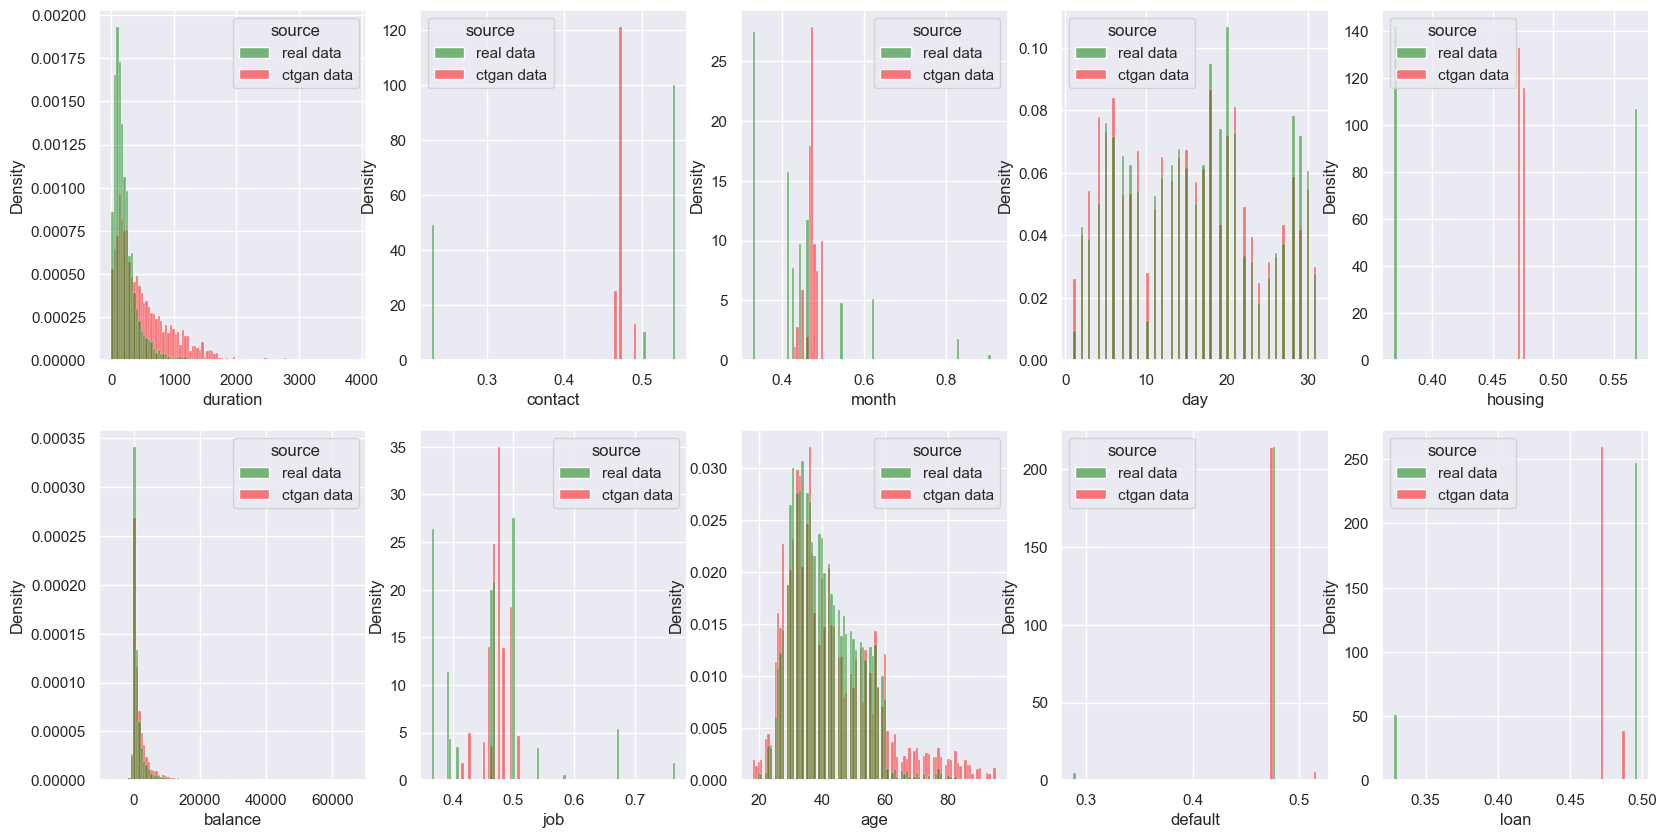

In [20]:
neg_real_train_df = encoded_X_train[sel_features].loc[y_train[y_train==0].index]
neg_real_train_df['source'] = 'real data'
neg_ctgan_train_df = encoded_ctgan_syn_X_train[sel_features].loc[y_train[y_train==0].index]
neg_ctgan_train_df['source'] = 'ctgan data'
neg_train_df = pd.concat([neg_real_train_df, neg_ctgan_train_df], 
                         ignore_index=True)

plot_num_feature_distribution_per_group(neg_train_df, group_col='source', n_rows=2, n_cols=5, exclude_col=[], 
                                            figsize=[20, 10], font_scale=1, 
                                            bins=100, palette=['green', 'red'])

## Observations

* In CTGAN generated training data, negative class values in top impactful features had confused with their feature values in real data's positve class, such as 'duration', 'age', etc., and finally dragged down model prediction performance.

## So, what if separatedly generate synthetic data for each class?

* The assumption is, by generate synthetic data for each class, can reduce a class' feature values be affected by another class' feature values.
* To use CTGAN is simpler than CasTGAN, and their performance didn't have much difference, so the code below only uses CTGAN to experiment.

In [21]:
from ctgan import CTGAN
from ttictoc import tic,toc
from sklearn.utils import shuffle

cols = list(X_train.columns)
X_train_pos = X_train.loc[y_train[y_train==1].index]
X_train_neg = X_train.loc[y_train[y_train==0].index]
print(X_train_pos.shape, X_train_neg.shape)

(3967, 16) (4404, 16)


In [22]:
def get_new_syn_data(syn_X_train_pos, syn_X_train_neg):
    syn_X_train_pos['y_true'] = 1
    syn_X_train_neg['y_true'] = 0
    new_syn_train = pd.concat([syn_X_train_pos, syn_X_train_neg], ignore_index=True)
    print(new_syn_train.shape)

    new_syn_train = shuffle(new_syn_train, random_state=10).reset_index(drop=True)
    
    return new_syn_train

In [29]:
# Generate new CTGAN synthetic data
tic()
ctgan_pos = CTGAN(epochs=10)
ctgan_pos.set_random_state(10)  # to make output replicable
ctgan_pos.fit(X_train_pos, cols)
print(f'{round(toc()/60.0, 1)} min')

tic()
ctgan_neg = CTGAN(epochs=10)
ctgan_neg.set_random_state(10)
ctgan_neg.fit(X_train_neg, cols)
print(f'{round(toc()/60.0, 1)} min')

ctgan_X_train_pos = ctgan_pos.sample(len(X_train_pos))
ctgan_X_train_neg = ctgan_neg.sample(len(X_train_neg))

print(ctgan_X_train_pos.shape, ctgan_X_train_neg.shape)

5.1 min
4.6 min
(3967, 16) (4404, 16)


In [30]:
new_syn_ctgan_train = get_new_syn_data(ctgan_X_train_pos, ctgan_X_train_neg)
new_syn_ctgan_X_train = new_syn_ctgan_train[cols]
new_syn_ctgan_y_train = new_syn_ctgan_train['y_true']

new_encoded_ctgan_syn_X_train = encode_data(cat_cols, new_syn_ctgan_X_train, new_syn_ctgan_y_train)
print(new_encoded_ctgan_syn_X_train.shape, encoded_X_test.shape)

(8371, 17)
(8371, 16) (2791, 16)


In [31]:
model_params = {'num_leaves': 4, 'learning_rate': 0.17937097905882862, 
                'bagging_fraction': 0.8506740422636537, 'feature_fraction': 0.6643670461510903,
                'bagging_freq': 18, 'min_data_in_leaf': 1133, 'num_iterations': 2956, 
                'objective': 'binary', 'metric': 'auc', 'random_state': 10,
                'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4}

model_ctgan = LGBMClassifier(**model_params)
model_ctgan.fit(new_encoded_ctgan_syn_X_train, new_syn_ctgan_y_train)
new_ctgan_y_pred = model_ctgan.predict(encoded_X_test)
auc = roc_auc_score(y_test, new_ctgan_y_pred)
avp = average_precision_score(y_test, new_ctgan_y_pred)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')  # using target encoding seems lowered the performance

Testing AUC is 0.6692919427111387, Testing Average Precision is 0.6209274087165866
